    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4914104/
    За основу взята данная архитектура: сворачивание входных данных, затем bilstm.
    
    В качестве входных данных использовались one-hot последовательности длинной от 5 до 30 символов и предсказывался следующий символ, те бралась только информация слева.

`(test 0.42)`
`(эпох 160, батч 200)`

### Libraries

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import LSTM, Bidirectional, Conv1D, MaxPool1D 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.backend.tensorflow_backend import set_session
from keras import backend as K
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
curruser = os.environ.get('USER')

import pandas as pd
import numpy as np

import sys
sys.path.append('./src')
from PreprocInput import preproc_

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


### Set GPU

In [24]:
with K.tf.device('/GPU:0'):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.6
    session = tf.Session(config=config)
    K.set_session(session)

### Secondary functions

In [3]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [4]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load dataset and preproc

In [3]:
data = pd.read_csv('./data/LeftWrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


In [4]:
data.shape

(3351352, 2)

In [5]:
chars = sorted(list(set(data.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
indices_char

{0: 'A', 1: 'C', 2: 'G', 3: 'T'}

In [6]:
MAXSEQLEN = max(map(len, data.seq.values))

X_data, y_data = preproc_.get_input_array(data.seq.values, data.label.values, MAXSEQLEN , chars, char_indices)
X_data.shape, y_data.shape

((3351352, 30, 4), (3351352, 4))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True)

# Build and train model: CNN+BILSTM

In [12]:
def danq_model(seq_length, vocab_size):

    model = Sequential()
    model.add(Conv1D(input_shape=(seq_length, vocab_size),
                        kernel_size=6,
                        filters=120,
                        padding="valid",
                        activation="tanh"))

    model.add(MaxPool1D(pool_size=4, strides=4))
    
    model.add(BatchNormalization())

    model.add(Dropout(0.2))

    model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))


    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('tanh'))

    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

model = danq_model(MAXSEQLEN, len(chars))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 120)           3000      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 120)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 120)            480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 120)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6, 256)            254976    
_________________________________________________________________
flatten_1 (Flatten)  

In [ ]:
path = './same_/danq_hybrid.h5'

callbacks = [EarlyStopping(patience=10, monitor='val_loss'),
                 ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

BATCH_SIZE=200
n_epoch=160

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

Instructions for updating:
Use tf.cast instead.
Train on 2144864 samples, validate on 536217 samples
Epoch 1/160
2144864/2144864 [==============================] - 413s 193us/step - loss: 1.3486 - acc: 0.3282 - val_loss: 1.3373 - val_acc: 0.3395

Epoch 00001: val_loss improved from inf to 1.33729, saving model to ./same_/danq_hybrid.h5
Epoch 2/160
2144864/2144864 [==============================] - 408s 190us/step - loss: 1.3347 - acc: 0.3408 - val_loss: 1.3267 - val_acc: 0.3487

Epoch 00002: val_loss improved from 1.33729 to 1.32672, saving model to ./same_/danq_hybrid.h5
Epoch 3/160
2144864/2144864 [==============================] - 407s 190us/step - loss: 1.3271 - acc: 0.3480 - val_loss: 1.3199 - val_acc: 0.3535

Epoch 00003: val_loss improved from 1.32672 to 1.31990, saving model to ./same_/danq_hybrid.h5
Epoch 4/160
2144864/2144864 [==============================] - 406s 189us/step - loss: 1.3214 - acc: 0.3533 - val_loss: 1.3134 - val_acc: 0.3599

Epoch 00004: val_loss improved fro

2144864/2144864 [==============================] - 367s 171us/step - loss: 1.2566 - acc: 0.4155 - val_loss: 1.2585 - val_acc: 0.4123

Epoch 00034: val_loss improved from 1.25912 to 1.25847, saving model to ./same_/danq_hybrid.h5
Epoch 35/160
2144864/2144864 [==============================] - 369s 172us/step - loss: 1.2567 - acc: 0.4157 - val_loss: 1.2584 - val_acc: 0.4126

Epoch 00035: val_loss improved from 1.25847 to 1.25842, saving model to ./same_/danq_hybrid.h5
Epoch 36/160
2144864/2144864 [==============================] - 367s 171us/step - loss: 1.2561 - acc: 0.4162 - val_loss: 1.2581 - val_acc: 0.4130

Epoch 00036: val_loss improved from 1.25842 to 1.25809, saving model to ./same_/danq_hybrid.h5
Epoch 37/160
2144864/2144864 [==============================] - 366s 171us/step - loss: 1.2556 - acc: 0.4165 - val_loss: 1.2580 - val_acc: 0.4129

Epoch 00037: val_loss improved from 1.25809 to 1.25803, saving model to ./same_/danq_hybrid.h5
Epoch 38/160
2144864/2144864 [===============

In [ ]:
plot_metrics(history)

# OOB validation

In [52]:
model = load_model(path)

In [15]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

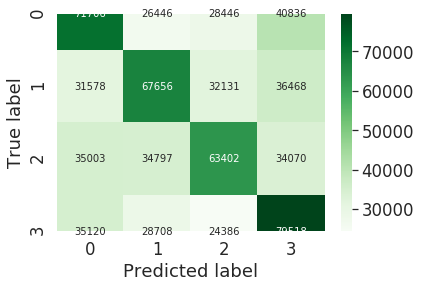

In [16]:
confusion_matrix_heatmap(y_true, y_pred)

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.43      0.42    167434
           1       0.43      0.40      0.42    167833
           2       0.43      0.38      0.40    167272
           3       0.42      0.47      0.44    167732

    accuracy                           0.42    670271
   macro avg       0.42      0.42      0.42    670271
weighted avg       0.42      0.42      0.42    670271

